In [1]:
from pathlib import Path

from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.ml.feature import StringIndexer

import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = Path().resolve().parent
DATA_PATH = (ROOT_PATH / "data" ).resolve()

In [3]:
DATA_PATH

PosixPath('/home/reezo/Documents/Fraud detection/data')

In [4]:
spark = SparkSession.builder\
    .appName("Fraud_Detection")\
    .master("local[*]")\
    .config("spark.sql.shuffle.partitions", "8")\
    .config("spark.driver.memory", "12g")\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/06 18:44:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df_transactions = spark.read.csv(str(DATA_PATH / 'raw'/ 'train_transaction.csv'), inferSchema=True, header=True)
df_identity = spark.read.csv(str(DATA_PATH / 'raw'/'train_identity.csv'), inferSchema=True, header=True)

In [6]:
shape = (df_transactions.count(), len(df_transactions.columns))
shape

(590540, 394)

In [7]:
shape = (df_identity.count(), len(df_identity.columns))
shape

(144233, 41)

In [8]:
df = df_transactions.join(df_identity, on='TransactionID', how='left')
shape = (df.count(), len(df.columns))
shape

(590540, 434)

In [9]:
total_col = 590540
null_count = [
    (sf.count(sf.when(sf.col(c).isNull(), 1)) / total_col).alias(c)
    for c in df.columns
]

null_percent_df = df.select(*null_count)

null_percent_dict = null_percent_df.collect()[0].asDict()

25/12/06 18:44:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/06 18:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB


In [10]:
#null_percent_dict

In [11]:
NULL_THRESHOLD = 0.90

col_to_drop = [
    colname for colname, percentaje in null_percent_dict.items()
    if percentaje > NULL_THRESHOLD
]

df_clean = df.drop(*col_to_drop)

print(f"columns to drop ", col_to_drop)
print((df.count(), len(df.columns)))

columns to drop  ['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
(590540, 434)


In [12]:
dtype_df = spark.createDataFrame([
    (col_name, col_type) for col_name, col_type in df_clean.dtypes
], ["Columna", "Tipo de Dato"])

#dtype_df.show(n=1000, truncate=False)

In [13]:
df_clean.select(sf.when(sf.col('isFraud') == 1, 1)).count()

590540

In [14]:
fraud_count = df_clean.select(
    sf.sum(sf.when(sf.col('isFraud') == 1, 1)).alias('fraud_count')
    ).collect()[0]['fraud_count']

no_fraud_count = df_clean.select(
    sf.sum(sf.when(sf.col('isFraud') == 0, 1)).alias('no_fraud_count')
).collect()[0]['no_fraud_count']

print(fraud_count)
print(no_fraud_count)

20663
569877


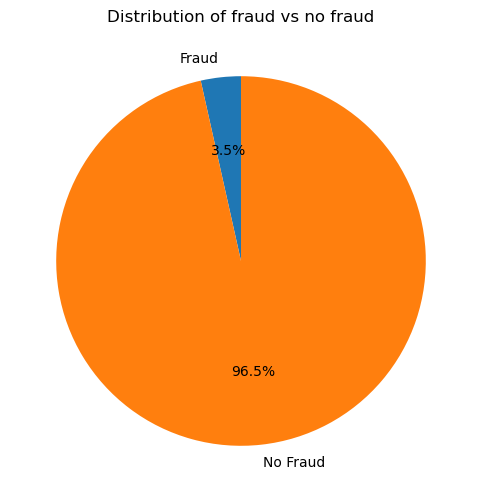

In [15]:
sizes = [fraud_count, no_fraud_count]
labels = ['Fraud', 'No Fraud']

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)

plt.title('Distribution of fraud vs no fraud')
plt.show()

In [16]:
df_clean.select('TransactionDT').describe().show()

+-------+-----------------+
|summary|    TransactionDT|
+-------+-----------------+
|  count|           590540|
|   mean|7372311.310116165|
| stddev|4617223.646539679|
|    min|            86400|
|    max|         15811131|
+-------+-----------------+



In [17]:
# The data of TransactionDT is counted as seconds from the day 0, so I have to convert it to usable variables

seconds_per_day = sf.lit(24 * 3600)
seconds_per_hour = sf.lit(3600)

df_clean = df_clean.withColumns({
    "hour":
        (sf.col("TransactionDT") % seconds_per_day / seconds_per_hour),
    "Day_of_week":
        sf.floor(sf.col("TransactionDT") / seconds_per_day % sf.lit(7)),
    "Day_of_month":
        sf.floor(sf.col("TransactionDT") / seconds_per_day % sf.lit(30))
})

#df_clean = df_clean.drop("TransactionDT")

In [18]:
device_info_subdata = df_clean.select(sf.col("DeviceInfo")).distinct().count()
device_info_subdata

1787

In [19]:
#df_clean.groupBy("DeviceType").show(n=10, truncate=False)

df_clean.groupBy('DeviceInfo') \
    .count() \
    .orderBy(sf.desc('count')) \
    .show(n=10, truncate=False)

+---------------------+------+
|DeviceInfo           |count |
+---------------------+------+
|NULL                 |471874|
|Windows              |47722 |
|iOS Device           |19782 |
|MacOS                |12573 |
|Trident/7.0          |7440  |
|rv:11.0              |1901  |
|rv:57.0              |962   |
|SM-J700M Build/MMB29K|549   |
|SM-G610M Build/MMB29K|461   |
|SM-G531H Build/LMY48B|410   |
+---------------------+------+
only showing top 10 rows


In [20]:
df_clean = df_clean.withColumns({
    "P_emaildomain_1":
        sf.split(sf.col("P_emaildomain"), pattern=sf.lit('.')).getItem(0),
    "P_emaildomain_2":
        sf.split(sf.col("P_emaildomain"), pattern=sf.lit('.')).getItem(1),
    "P_emaildomain_3":
        sf.split(sf.col("P_emaildomain"), pattern=sf.lit('.')).getItem(2)
}).withColumns({
    "R_emaildomain_1":
        sf.split(sf.col("R_emaildomain"), pattern=sf.lit('.')).getItem(0),
    "R_emaildomain_2":
        sf.split(sf.col("R_emaildomain"), pattern=sf.lit('.')).getItem(1),
    "R_emaildomain_3":
        sf.split(sf.col("R_emaildomain"), pattern=sf.lit('.')).getItem(2)
})


df_clean = df_clean.drop("P_emaildomain", "R_emaildomain")

In [21]:
def low_variance_cols(dataframe, threshold=0.1):
    df = dataframe.drop("isFraud", "TransactionID")
    num_cols = [
        col_name for col_name, col_type in df_clean.dtypes
        if col_type in ["int", "bigint", "float", "double"] and col_name not in ["isFraud", "TransactionID"]
    ]

    variance_expressions = [sf.variance(sf.col(c)).alias(c) for c in num_cols]
    
    variance_row = df.select(*variance_expressions).collect()[0]

    low_variance_cols = [
        col_name for col_name in num_cols
        if variance_row[col_name] is not None and variance_row[col_name] < threshold
    ]
    
    return low_variance_cols

df_clean = df_clean.drop(*low_variance_cols(df_clean, threshold=0.9))

25/12/06 18:44:35 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
25/12/06 18:44:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [22]:
# Null value handling

num_cols = [
    col_name for col_name, col_type in df_clean.dtypes
    if col_type in ["int", "bigint", "float", "double"] and col_name not in ["isFraud", "TransactionID"]
]

string_cols = [
    col_name for col_name, col_type in df_clean.dtypes
    if col_type == "string"
]

df_clean = df_clean.fillna( -999, num_cols)
df_clean = df_clean.fillna("UNKNOWN", string_cols)

In [23]:
output_cols = [col + "_Encoded" for col in string_cols]

indexer = StringIndexer(inputCols=string_cols, outputCols=output_cols)
indexer_model = indexer.fit(df_clean)
df_clean = indexer_model.transform(df_clean)

df_clean = df_clean.drop(*string_cols)

In [24]:
cutoff_time = df_clean.approxQuantile("TransactionDT", [0.8], 0.001)[0]

train_df = df_clean.filter(sf.col("TransactionDT") <= cutoff_time)
val_df = df_clean.filter(sf.col("TransactionDT") > cutoff_time)

train_df = train_df.drop("TransactionDT")
val_df = val_df.drop("TransactionDT")

print(f"Train set: {train_df.count()} rows")
print(f"Validation set: {val_df.count()} rows")

Train set: 472412 rows
Validation set: 118128 rows


In [25]:
train_df.write.mode("overwrite").parquet(str(DATA_PATH/"processed"/ "train_df.parquet"))
val_df.write.mode("overwrite").parquet(str(DATA_PATH/"processed"/ "val_df.parquet"))

In [26]:
len(train_df.columns)

249